# Geospatial Big Data Analytics Lab 6

Ευάγγελος Τσόγκας 03400120

Σε αυτή την εργασία θα ασχοληθούμε με CNN και transfer learning.

In [6]:
import json
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms

## Part A: Classification with pretrained networks

Στο πρώτο μέρος της εργασίας πειραματίζομαι με 5 προεκπαιδευμένα δίκτυα: AlexNet, VGG19, Inceptionv3, ResNet-152 και DenseNet-161. Σκοπός είναι η κατηγοριοποίηση εικόνων που έχω επιλέξει απ' το internet οι οποίες ανήκουν σε συνολικά 5 κατηγορίες του ImageNet: goldfish, hen, bald_eagle, hummingbird και peacock. Παρακάτω φαίνονται τα urls τεσσάρων εικόνων από κάθε κατηγορία.

In [7]:
# image links
goldfish_urls = [
    'https://i.guim.co.uk/img/media/9c03bd43c119834ece958f3c370dec83146fe04a/0_200_6000_3602/master/6000.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=de1abf11d1a7a961d5fea63f5a8bee55',
    'https://www.tfhmagazine.com/-/media/Images/TFH2-NA/US/articles/227_goldfish_myths_debunked.jpg',
    'https://www.telegraph.co.uk/content/dam/pets/2016/07/25/IMG_0875-Ricky-fish-PETS_trans_NvBQzQNjv4BqtJ6f5EZqCBq61C5NdEPcFKRH8VZ7DUi4_n_BPSdb5rc.JPG',
    'https://i.ndtvimg.com/i/2016-02/goldfish-gold-fish-generic_650x400_61455699497.jpg'
]
hen_urls = [
    'https://www.bhwt.org.uk/wp-content/uploads/2020/02/hen-examination-guidelines.jpg',
    'https://images.theconversation.com/files/239356/original/file-20181004-52660-1fosymz.jpg?ixlib=rb-1.1.0&rect=121%2C5%2C3214%2C2309&q=45&auto=format&w=926&fit=clip',
    'https://www.organicgardener.com.au/sites/default/files/styles/620x/public/images/blogs/iStock_000045742478_Med.jpg?itok=DBnrZRyU',
    'https://morningchores.com/wp-content/uploads/2019/05/The-Ultimate-Guide-to-Handling-Broody-Hens-FI.jpg'
]
bald_eagle_urls = [
    'https://nas-national-prod.s3.amazonaws.com/web_h_p1_4047_1_bald-eagle_bonnie_block_kk-adult.jpg',
    'https://cdn.download.ams.birds.cornell.edu/api/v1/asset/306063271/1800',
    'https://www.wkms.org/sites/wkms/files/201911/1920px-a_banded_adult_bald_eagle__5657709617_.jpg',
    'https://inteng-storage.s3.amazonaws.com/img/iea/BxG2137dO9/sizes/bald-eagle-killer-design_resize_md.jpg'
]
hummingbird_urls = [
    'https://i.guim.co.uk/img/media/f37bea35dcfe441e90990cd6e0ef5eb8f8898c9c/0_0_2515_1508/master/2515.jpg?width=1200&quality=85&auto=format&fit=max&s=6bebecbb02599488c61bfc928fa18cd6',
    'https://cdn.mos.cms.futurecdn.net/j4wLX6ZTJqcki9AFrjRcUm-1200-80.jpg',
    'https://www.eurekalert.org/multimedia/pub/web/230094_web.jpg',
    'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/2-gettyimages-589055528-jpg-1567793340.jpg?crop=1xw:1xh;center,top&resize=480:*'
]
peacock_urls = [
    'https://i.pinimg.com/originals/44/00/13/440013c29c743609e495ee233504c426.jpg',
    'https://cdn.britannica.com/37/154237-050-A76A506D/blue-peafowl-tail-Indian-peacock-courtship-displays.jpg',
    'https://ichef.bbci.co.uk/images/ic/640x360/p06f7mx9.jpg',
    'https://www.gannett-cdn.com/presto/2020/05/28/PIND/bfae515d-aae9-41cb-a49f-9236d97f1800-Craig_Bowen.jpg?width=660&height=660&fit=crop&format=pjpg&auto=webp'
]

Στη συνέχεια, φτιάχνω μια λίστα με τις κλάσεις των εικόνων, φορτώνω τα προεκπαιδευμένα μοντέλα, τα ονόματα των κλάσεων του ImageNet και ορίζω το transform των εικόνων και τη μέθοδο για τη λήψη των προβλέψεων.

In [8]:
# list with classes of chosen images
classes = ['goldfish'] * 4 + ['hen'] * 4 + ['bald_eagle'] * 4 + ['hummingbird'] * 4 + ['peacock'] * 4

# get default device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load models
alexnet = models.alexnet(pretrained=True).to(device).eval()
vgg19 = models.vgg19(pretrained=True).to(device).eval()
inception_v3 = models.inception_v3(pretrained=True).to(device).eval()
resnet152 = models.resnet152(pretrained=True).to(device).eval()
densenet161 = models.densenet161(pretrained=True).to(device).eval()

# define transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

# Load 1000 class names of ImageNet for inference
with urlopen("https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json") as url:
    cls_dict = json.loads(url.read().decode())


# Get the top-5 predicted probabilities for each class
def get_predictions(model, image):
    out = model(image.view(1, 3, 224, 224))
    probabilities, cls_indices = torch.nn.functional.softmax(out, dim=-1).topk(5)
    cls_labels = [cls_dict[str(int(i))][-1] for i in cls_indices.view(-1)]
    probabilities = probabilities.detach().cpu().numpy().squeeze() * 100
    for i in range(5):
        print(f'#{i + 1}: {cls_labels[i]} -- {probabilities[i]:02.1f}%')
    return cls_labels

Στο παρακάτω loop παίρνω τις προβλέψεις κάθε μοντέλου για κάθε εικόνα και υπολογίζω πόσες top1 και top5 σωστές προβλέψεις είχε κάθε μοντέλο.

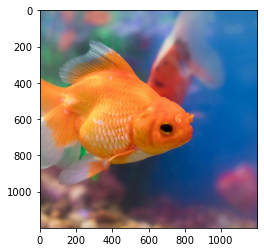

alexnet: ------------------------------
#1: goldfish -- 100.0%
#2: axolotl -- 0.0%
#3: sea_slug -- 0.0%
#4: banded_gecko -- 0.0%
#5: eft -- 0.0%

vgg19: ------------------------------
#1: goldfish -- 100.0%
#2: rock_beauty -- 0.0%
#3: anemone_fish -- 0.0%
#4: axolotl -- 0.0%
#5: coral_reef -- 0.0%

inception_v3: ------------------------------
#1: goldfish -- 100.0%
#2: ambulance -- 0.0%
#3: hartebeest -- 0.0%
#4: cash_machine -- 0.0%
#5: butcher_shop -- 0.0%

resnet152: ------------------------------
#1: goldfish -- 100.0%
#2: rock_beauty -- 0.0%
#3: anemone_fish -- 0.0%
#4: puffer -- 0.0%
#5: coral_reef -- 0.0%

densenet161: ------------------------------
#1: goldfish -- 100.0%
#2: rock_beauty -- 0.0%
#3: anemone_fish -- 0.0%
#4: coral_reef -- 0.0%
#5: axolotl -- 0.0%


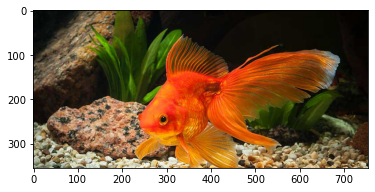

alexnet: ------------------------------
#1: goldfish -- 99.3%
#2: macaw -- 0.6%
#3: cock -- 0.1%
#4: lorikeet -- 0.0%
#5: anemone_fish -- 0.0%

vgg19: ------------------------------
#1: goldfish -- 100.0%
#2: macaw -- 0.0%
#3: anemone_fish -- 0.0%
#4: sea_anemone -- 0.0%
#5: coral_reef -- 0.0%

inception_v3: ------------------------------
#1: goldfish -- 100.0%
#2: ambulance -- 0.0%
#3: puffer -- 0.0%
#4: rock_beauty -- 0.0%
#5: anemone_fish -- 0.0%

resnet152: ------------------------------
#1: goldfish -- 99.8%
#2: rock_beauty -- 0.1%
#3: anemone_fish -- 0.0%
#4: tench -- 0.0%
#5: axolotl -- 0.0%

densenet161: ------------------------------
#1: goldfish -- 100.0%
#2: anemone_fish -- 0.0%
#3: tench -- 0.0%
#4: sea_anemone -- 0.0%
#5: axolotl -- 0.0%


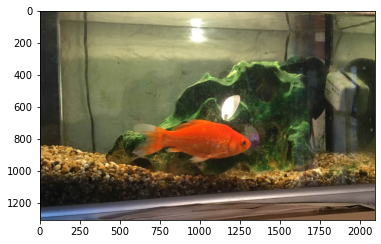

alexnet: ------------------------------
#1: goldfish -- 100.0%
#2: lorikeet -- 0.0%
#3: axolotl -- 0.0%
#4: frying_pan -- 0.0%
#5: eft -- 0.0%

vgg19: ------------------------------
#1: goldfish -- 100.0%
#2: coral_reef -- 0.0%
#3: lorikeet -- 0.0%
#4: rock_beauty -- 0.0%
#5: anemone_fish -- 0.0%

inception_v3: ------------------------------
#1: goldfish -- 100.0%
#2: ambulance -- 0.0%
#3: hartebeest -- 0.0%
#4: candle -- 0.0%
#5: rock_beauty -- 0.0%

resnet152: ------------------------------
#1: goldfish -- 100.0%
#2: rock_beauty -- 0.0%
#3: axolotl -- 0.0%
#4: tench -- 0.0%
#5: terrapin -- 0.0%

densenet161: ------------------------------
#1: goldfish -- 100.0%
#2: axolotl -- 0.0%
#3: eft -- 0.0%
#4: volcano -- 0.0%
#5: tench -- 0.0%


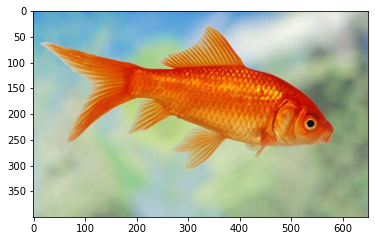

alexnet: ------------------------------
#1: goldfish -- 100.0%
#2: agaric -- 0.0%
#3: starfish -- 0.0%
#4: banded_gecko -- 0.0%
#5: spoonbill -- 0.0%

vgg19: ------------------------------
#1: goldfish -- 100.0%
#2: tench -- 0.0%
#3: gar -- 0.0%
#4: barracouta -- 0.0%
#5: rock_beauty -- 0.0%

inception_v3: ------------------------------
#1: goldfish -- 100.0%
#2: tench -- 0.0%
#3: ambulance -- 0.0%
#4: gar -- 0.0%
#5: barracouta -- 0.0%

resnet152: ------------------------------
#1: goldfish -- 100.0%
#2: rock_beauty -- 0.0%
#3: tench -- 0.0%
#4: barracouta -- 0.0%
#5: gar -- 0.0%

densenet161: ------------------------------
#1: goldfish -- 100.0%
#2: barracouta -- 0.0%
#3: tench -- 0.0%
#4: gar -- 0.0%
#5: coho -- 0.0%


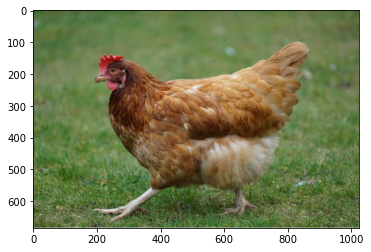

alexnet: ------------------------------
#1: hen -- 92.9%
#2: cock -- 7.0%
#3: crane -- 0.1%
#4: house_finch -- 0.0%
#5: partridge -- 0.0%

vgg19: ------------------------------
#1: hen -- 94.5%
#2: cock -- 5.4%
#3: partridge -- 0.2%
#4: ruffed_grouse -- 0.0%
#5: crane -- 0.0%

inception_v3: ------------------------------
#1: hen -- 100.0%
#2: cock -- 0.0%
#3: mailbox -- 0.0%
#4: partridge -- 0.0%
#5: gyromitra -- 0.0%

resnet152: ------------------------------
#1: hen -- 99.6%
#2: cock -- 0.3%
#3: partridge -- 0.0%
#4: ruffed_grouse -- 0.0%
#5: vulture -- 0.0%

densenet161: ------------------------------
#1: hen -- 98.4%
#2: cock -- 1.2%
#3: partridge -- 0.1%
#4: ruffed_grouse -- 0.1%
#5: black_grouse -- 0.0%


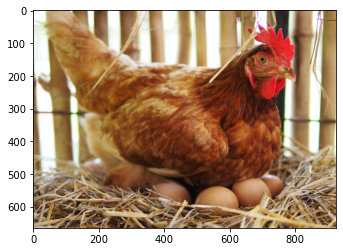

alexnet: ------------------------------
#1: hen -- 81.7%
#2: cock -- 12.9%
#3: butcher_shop -- 0.8%
#4: partridge -- 0.3%
#5: grocery_store -- 0.2%

vgg19: ------------------------------
#1: hen -- 96.6%
#2: cock -- 3.0%
#3: partridge -- 0.4%
#4: ruffed_grouse -- 0.0%
#5: quail -- 0.0%

inception_v3: ------------------------------
#1: hen -- 99.7%
#2: cock -- 0.3%
#3: partridge -- 0.0%
#4: ruffed_grouse -- 0.0%
#5: prairie_chicken -- 0.0%

resnet152: ------------------------------
#1: hen -- 97.5%
#2: cock -- 2.5%
#3: partridge -- 0.0%
#4: ruffed_grouse -- 0.0%
#5: vulture -- 0.0%

densenet161: ------------------------------
#1: hen -- 97.0%
#2: cock -- 3.0%
#3: ruffed_grouse -- 0.0%
#4: partridge -- 0.0%
#5: black_grouse -- 0.0%


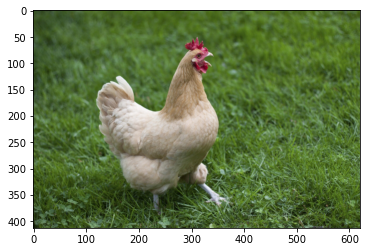

alexnet: ------------------------------
#1: hen -- 82.9%
#2: cock -- 17.1%
#3: drake -- 0.0%
#4: house_finch -- 0.0%
#5: white_stork -- 0.0%

vgg19: ------------------------------
#1: hen -- 69.9%
#2: cock -- 30.0%
#3: partridge -- 0.1%
#4: peacock -- 0.0%
#5: goose -- 0.0%

inception_v3: ------------------------------
#1: hen -- 98.6%
#2: cock -- 1.4%
#3: partridge -- 0.0%
#4: mailbox -- 0.0%
#5: llama -- 0.0%

resnet152: ------------------------------
#1: hen -- 97.6%
#2: cock -- 2.4%
#3: partridge -- 0.0%
#4: ptarmigan -- 0.0%
#5: ruffed_grouse -- 0.0%

densenet161: ------------------------------
#1: hen -- 91.7%
#2: cock -- 8.2%
#3: partridge -- 0.0%
#4: ptarmigan -- 0.0%
#5: goose -- 0.0%


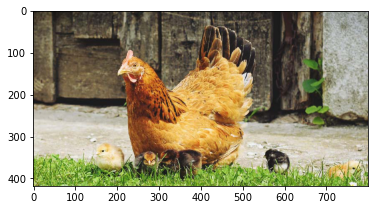

alexnet: ------------------------------
#1: hen -- 94.8%
#2: cock -- 5.0%
#3: partridge -- 0.0%
#4: gyromitra -- 0.0%
#5: coral_fungus -- 0.0%

vgg19: ------------------------------
#1: hen -- 96.4%
#2: cock -- 3.4%
#3: partridge -- 0.2%
#4: ruffed_grouse -- 0.0%
#5: quail -- 0.0%

inception_v3: ------------------------------
#1: hen -- 98.9%
#2: cock -- 1.1%
#3: partridge -- 0.0%
#4: mailbox -- 0.0%
#5: ruffed_grouse -- 0.0%

resnet152: ------------------------------
#1: hen -- 98.6%
#2: cock -- 1.3%
#3: partridge -- 0.0%
#4: ruffed_grouse -- 0.0%
#5: dhole -- 0.0%

densenet161: ------------------------------
#1: hen -- 98.0%
#2: cock -- 2.0%
#3: partridge -- 0.0%
#4: ruffed_grouse -- 0.0%
#5: prairie_chicken -- 0.0%


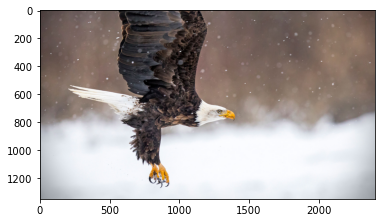

alexnet: ------------------------------
#1: bald_eagle -- 86.1%
#2: drake -- 2.9%
#3: honeycomb -- 1.6%
#4: Cardigan -- 0.8%
#5: American_alligator -- 0.5%

vgg19: ------------------------------
#1: bald_eagle -- 99.9%
#2: kite -- 0.1%
#3: vulture -- 0.0%
#4: ruffed_grouse -- 0.0%
#5: hen -- 0.0%

inception_v3: ------------------------------
#1: bald_eagle -- 100.0%
#2: albatross -- 0.0%
#3: black_swan -- 0.0%
#4: spotlight -- 0.0%
#5: oil_filter -- 0.0%

resnet152: ------------------------------
#1: bald_eagle -- 99.9%
#2: kite -- 0.1%
#3: albatross -- 0.0%
#4: black_grouse -- 0.0%
#5: prairie_chicken -- 0.0%

densenet161: ------------------------------
#1: bald_eagle -- 99.9%
#2: kite -- 0.1%
#3: prairie_chicken -- 0.0%
#4: black_grouse -- 0.0%
#5: king_penguin -- 0.0%


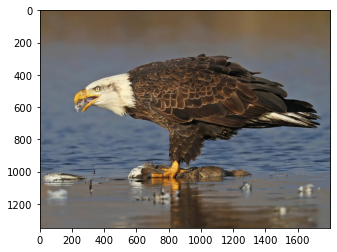

alexnet: ------------------------------
#1: bald_eagle -- 97.6%
#2: red-backed_sandpiper -- 1.0%
#3: kite -- 0.3%
#4: water_ouzel -- 0.3%
#5: bittern -- 0.2%

vgg19: ------------------------------
#1: bald_eagle -- 99.8%
#2: kite -- 0.2%
#3: goose -- 0.0%
#4: vulture -- 0.0%
#5: limpkin -- 0.0%

inception_v3: ------------------------------
#1: bald_eagle -- 100.0%
#2: pill_bottle -- 0.0%
#3: spotlight -- 0.0%
#4: black_swan -- 0.0%
#5: daisy -- 0.0%

resnet152: ------------------------------
#1: bald_eagle -- 99.9%
#2: kite -- 0.1%
#3: albatross -- 0.0%
#4: limpkin -- 0.0%
#5: vulture -- 0.0%

densenet161: ------------------------------
#1: bald_eagle -- 99.9%
#2: kite -- 0.1%
#3: goose -- 0.0%
#4: black_swan -- 0.0%
#5: albatross -- 0.0%


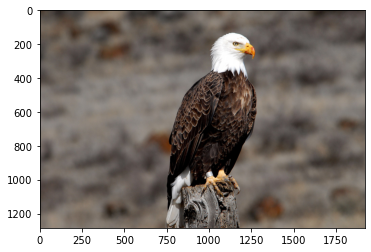

alexnet: ------------------------------
#1: bald_eagle -- 99.9%
#2: kite -- 0.1%
#3: hornbill -- 0.0%
#4: vulture -- 0.0%
#5: prairie_chicken -- 0.0%

vgg19: ------------------------------
#1: bald_eagle -- 100.0%
#2: kite -- 0.0%
#3: vulture -- 0.0%
#4: hornbill -- 0.0%
#5: albatross -- 0.0%

inception_v3: ------------------------------
#1: bald_eagle -- 100.0%
#2: pill_bottle -- 0.0%
#3: hornbill -- 0.0%
#4: kite -- 0.0%
#5: daisy -- 0.0%

resnet152: ------------------------------
#1: bald_eagle -- 99.4%
#2: kite -- 0.6%
#3: albatross -- 0.0%
#4: vulture -- 0.0%
#5: hornbill -- 0.0%

densenet161: ------------------------------
#1: bald_eagle -- 99.6%
#2: kite -- 0.4%
#3: black_grouse -- 0.0%
#4: vulture -- 0.0%
#5: prairie_chicken -- 0.0%


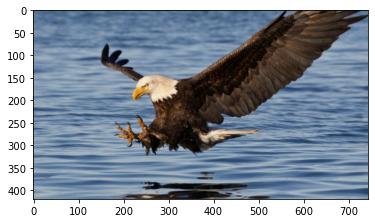

alexnet: ------------------------------
#1: bald_eagle -- 99.7%
#2: kite -- 0.1%
#3: pelican -- 0.0%
#4: oystercatcher -- 0.0%
#5: vulture -- 0.0%

vgg19: ------------------------------
#1: bald_eagle -- 100.0%
#2: albatross -- 0.0%
#3: kite -- 0.0%
#4: pelican -- 0.0%
#5: vulture -- 0.0%

inception_v3: ------------------------------
#1: bald_eagle -- 100.0%
#2: pelican -- 0.0%
#3: pill_bottle -- 0.0%
#4: albatross -- 0.0%
#5: white_stork -- 0.0%

resnet152: ------------------------------
#1: bald_eagle -- 99.9%
#2: albatross -- 0.0%
#3: kite -- 0.0%
#4: pelican -- 0.0%
#5: vulture -- 0.0%

densenet161: ------------------------------
#1: bald_eagle -- 99.7%
#2: albatross -- 0.2%
#3: pelican -- 0.0%
#4: American_egret -- 0.0%
#5: crane -- 0.0%


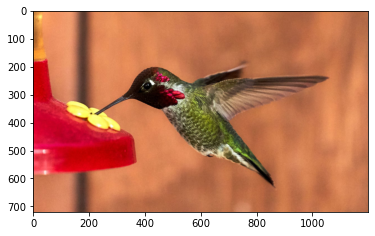

alexnet: ------------------------------
#1: hummingbird -- 99.9%
#2: bee_eater -- 0.1%
#3: jacamar -- 0.0%
#4: coucal -- 0.0%
#5: lorikeet -- 0.0%

vgg19: ------------------------------
#1: hummingbird -- 100.0%
#2: jacamar -- 0.0%
#3: bee_eater -- 0.0%
#4: bulbul -- 0.0%
#5: drake -- 0.0%

inception_v3: ------------------------------
#1: hummingbird -- 100.0%
#2: lawn_mower -- 0.0%
#3: castle -- 0.0%
#4: tricycle -- 0.0%
#5: prairie_chicken -- 0.0%

resnet152: ------------------------------
#1: hummingbird -- 100.0%
#2: jacamar -- 0.0%
#3: bee_eater -- 0.0%
#4: redshank -- 0.0%
#5: prairie_chicken -- 0.0%

densenet161: ------------------------------
#1: hummingbird -- 100.0%
#2: jacamar -- 0.0%
#3: bee_eater -- 0.0%
#4: redshank -- 0.0%
#5: water_ouzel -- 0.0%


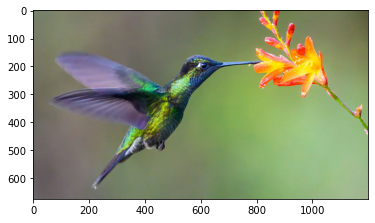

alexnet: ------------------------------
#1: hummingbird -- 99.2%
#2: bee_eater -- 0.5%
#3: jacamar -- 0.3%
#4: peacock -- 0.0%
#5: lorikeet -- 0.0%

vgg19: ------------------------------
#1: hummingbird -- 99.9%
#2: jacamar -- 0.1%
#3: bee_eater -- 0.0%
#4: peacock -- 0.0%
#5: agama -- 0.0%

inception_v3: ------------------------------
#1: hummingbird -- 100.0%
#2: jacamar -- 0.0%
#3: barrow -- 0.0%
#4: tricycle -- 0.0%
#5: peacock -- 0.0%

resnet152: ------------------------------
#1: hummingbird -- 100.0%
#2: jacamar -- 0.0%
#3: bee_eater -- 0.0%
#4: redshank -- 0.0%
#5: water_ouzel -- 0.0%

densenet161: ------------------------------
#1: hummingbird -- 100.0%
#2: jacamar -- 0.0%
#3: weevil -- 0.0%
#4: bee_eater -- 0.0%
#5: black_stork -- 0.0%


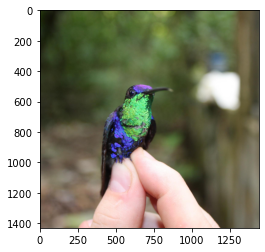

alexnet: ------------------------------
#1: hummingbird -- 85.0%
#2: jacamar -- 8.7%
#3: peacock -- 2.7%
#4: fly -- 1.2%
#5: indigo_bunting -- 0.7%

vgg19: ------------------------------
#1: jacamar -- 95.8%
#2: hummingbird -- 3.4%
#3: bee_eater -- 0.8%
#4: peacock -- 0.0%
#5: lorikeet -- 0.0%

inception_v3: ------------------------------
#1: jacamar -- 98.0%
#2: hummingbird -- 2.0%
#3: peacock -- 0.0%
#4: bee_eater -- 0.0%
#5: racer -- 0.0%

resnet152: ------------------------------
#1: hummingbird -- 93.5%
#2: jacamar -- 6.4%
#3: peacock -- 0.1%
#4: black_stork -- 0.0%
#5: bee_eater -- 0.0%

densenet161: ------------------------------
#1: hummingbird -- 69.3%
#2: jacamar -- 30.5%
#3: bee_eater -- 0.1%
#4: peacock -- 0.0%
#5: black_stork -- 0.0%


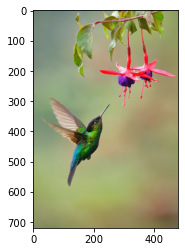

alexnet: ------------------------------
#1: hummingbird -- 80.7%
#2: pinwheel -- 5.2%
#3: dragonfly -- 3.2%
#4: leaf_beetle -- 1.0%
#5: tick -- 0.9%

vgg19: ------------------------------
#1: hummingbird -- 85.8%
#2: jacamar -- 14.2%
#3: bee_eater -- 0.0%
#4: peacock -- 0.0%
#5: weevil -- 0.0%

inception_v3: ------------------------------
#1: hummingbird -- 100.0%
#2: jacamar -- 0.0%
#3: monastery -- 0.0%
#4: peacock -- 0.0%
#5: pinwheel -- 0.0%

resnet152: ------------------------------
#1: hummingbird -- 99.5%
#2: jacamar -- 0.5%
#3: bee_eater -- 0.0%
#4: peacock -- 0.0%
#5: black_stork -- 0.0%

densenet161: ------------------------------
#1: hummingbird -- 96.2%
#2: jacamar -- 3.8%
#3: bee_eater -- 0.1%
#4: peacock -- 0.0%
#5: indigo_bunting -- 0.0%


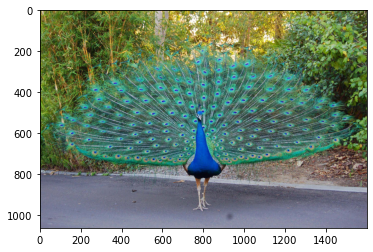

alexnet: ------------------------------
#1: peacock -- 100.0%
#2: indigo_bunting -- 0.0%
#3: jay -- 0.0%
#4: drake -- 0.0%
#5: magpie -- 0.0%

vgg19: ------------------------------
#1: peacock -- 100.0%
#2: fountain -- 0.0%
#3: cock -- 0.0%
#4: feather_boa -- 0.0%
#5: bubble -- 0.0%

inception_v3: ------------------------------
#1: peacock -- 100.0%
#2: fountain -- 0.0%
#3: European_gallinule -- 0.0%
#4: hummingbird -- 0.0%
#5: indigo_bunting -- 0.0%

resnet152: ------------------------------
#1: peacock -- 99.9%
#2: European_gallinule -- 0.0%
#3: indigo_bunting -- 0.0%
#4: fountain -- 0.0%
#5: umbrella -- 0.0%

densenet161: ------------------------------
#1: peacock -- 100.0%
#2: black_grouse -- 0.0%
#3: indigo_bunting -- 0.0%
#4: prairie_chicken -- 0.0%
#5: European_gallinule -- 0.0%


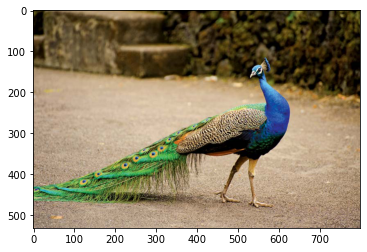

alexnet: ------------------------------
#1: peacock -- 100.0%
#2: agama -- 0.0%
#3: green_lizard -- 0.0%
#4: whiptail -- 0.0%
#5: European_gallinule -- 0.0%

vgg19: ------------------------------
#1: peacock -- 100.0%
#2: cock -- 0.0%
#3: llama -- 0.0%
#4: ostrich -- 0.0%
#5: bustard -- 0.0%

inception_v3: ------------------------------
#1: peacock -- 100.0%
#2: cock -- 0.0%
#3: hummingbird -- 0.0%
#4: tiger_beetle -- 0.0%
#5: bustard -- 0.0%

resnet152: ------------------------------
#1: peacock -- 100.0%
#2: European_gallinule -- 0.0%
#3: black_grouse -- 0.0%
#4: bustard -- 0.0%
#5: feather_boa -- 0.0%

densenet161: ------------------------------
#1: peacock -- 100.0%
#2: black_grouse -- 0.0%
#3: drake -- 0.0%
#4: tiger_beetle -- 0.0%
#5: European_gallinule -- 0.0%


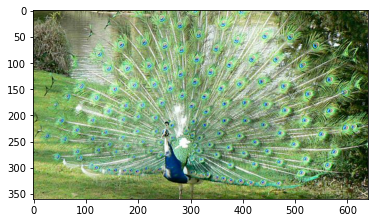

alexnet: ------------------------------
#1: peacock -- 100.0%
#2: lionfish -- 0.0%
#3: sea_urchin -- 0.0%
#4: sea_anemone -- 0.0%
#5: indigo_bunting -- 0.0%

vgg19: ------------------------------
#1: peacock -- 100.0%
#2: stole -- 0.0%
#3: feather_boa -- 0.0%
#4: water_bottle -- 0.0%
#5: wool -- 0.0%

inception_v3: ------------------------------
#1: peacock -- 100.0%
#2: sea_urchin -- 0.0%
#3: fountain -- 0.0%
#4: leaf_beetle -- 0.0%
#5: fly -- 0.0%

resnet152: ------------------------------
#1: peacock -- 100.0%
#2: umbrella -- 0.0%
#3: fountain -- 0.0%
#4: parachute -- 0.0%
#5: European_gallinule -- 0.0%

densenet161: ------------------------------
#1: peacock -- 100.0%
#2: black_grouse -- 0.0%
#3: fountain -- 0.0%
#4: indigo_bunting -- 0.0%
#5: drake -- 0.0%


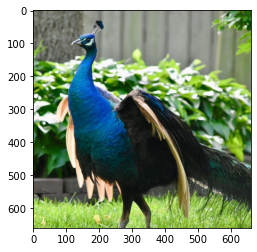

alexnet: ------------------------------
#1: peacock -- 98.5%
#2: European_gallinule -- 1.4%
#3: black_stork -- 0.0%
#4: jay -- 0.0%
#5: indigo_bunting -- 0.0%

vgg19: ------------------------------
#1: peacock -- 100.0%
#2: European_gallinule -- 0.0%
#3: magpie -- 0.0%
#4: cock -- 0.0%
#5: jay -- 0.0%

inception_v3: ------------------------------
#1: peacock -- 100.0%
#2: European_gallinule -- 0.0%
#3: indigo_bunting -- 0.0%
#4: llama -- 0.0%
#5: hummingbird -- 0.0%

resnet152: ------------------------------
#1: peacock -- 99.8%
#2: European_gallinule -- 0.1%
#3: cock -- 0.0%
#4: black_grouse -- 0.0%
#5: crane -- 0.0%

densenet161: ------------------------------
#1: peacock -- 100.0%
#2: European_gallinule -- 0.0%
#3: indigo_bunting -- 0.0%
#4: macaw -- 0.0%
#5: cock -- 0.0%


In [13]:
# track top1 and top5 correct predictions for each model
top1_correct = {'alexnet': 0, 'vgg19': 0, 'inception_v3': 0, 'resnet152': 0, 'densenet161': 0}
top5_correct = {'alexnet': 0, 'vgg19': 0, 'inception_v3': 0, 'resnet152': 0, 'densenet161': 0}

for i, url in enumerate(goldfish_urls + hen_urls + bald_eagle_urls + hummingbird_urls + peacock_urls):
    image = Image.open(urlopen(url))

    # show image
    plt.figure()
    plt.imshow(image)
    plt.show()
    
    # transform image
    image = transform(image).to(device)

    # get the top-5 predicted probabilities for each class and for each model
    print("alexnet: ------------------------------")
    predicted_labels = get_predictions(alexnet, image)
    top1_correct['alexnet'] += classes[i] == predicted_labels[0]
    top5_correct['alexnet'] += classes[i] in predicted_labels

    print("\nvgg19: ------------------------------")
    predicted_labels = get_predictions(vgg19, image)
    top1_correct['vgg19'] += classes[i] == predicted_labels[0]
    top5_correct['vgg19'] += classes[i] in predicted_labels

    print("\ninception_v3: ------------------------------")
    predicted_labels = get_predictions(inception_v3, image)
    top1_correct['inception_v3'] += classes[i] == predicted_labels[0]
    top5_correct['inception_v3'] += classes[i] in predicted_labels

    print("\nresnet152: ------------------------------")
    predicted_labels = get_predictions(resnet152, image)
    top1_correct['resnet152'] += classes[i] == predicted_labels[0]
    top5_correct['resnet152'] += classes[i] in predicted_labels

    print("\ndensenet161: ------------------------------")
    predicted_labels = get_predictions(densenet161, image)
    top1_correct['densenet161'] += classes[i] == predicted_labels[0]
    top5_correct['densenet161'] += classes[i] in predicted_labels

Τέλος, υπολογίζω το top1 και top5 accuracy των μοντέλων.

In [14]:
# calculate top1 and top5 accuracy for each model
for model in ['alexnet', 'vgg19', 'inception_v3', 'resnet152', 'densenet161']:
    print(model + ':')
    print("Top-1 accuracy =", top1_correct[model]/len(classes))
    print("Top-5 accuracy =", top5_correct[model]/len(classes))
    print()

alexnet:
Top-1 accuracy = 1.0
Top-5 accuracy = 1.0

vgg19:
Top-1 accuracy = 0.95
Top-5 accuracy = 1.0

inception_v3:
Top-1 accuracy = 0.95
Top-5 accuracy = 1.0

resnet152:
Top-1 accuracy = 1.0
Top-5 accuracy = 1.0

densenet161:
Top-1 accuracy = 1.0
Top-5 accuracy = 1.0



Παρατηρούμε πως όλα τα μοντέλα είχαν 100% top-5 accuracy, ενώ τα μόνα μοντέλα που δεν είχαν 100% top-1 accuracy είναι το VGG19 και το InceptionV3 τα οποία έκαναν ένα λάθος στην πρώτη τους πρόβλεψη. Και τα 2 αυτά μοντέλα έκαναν λάθος την 3η εικόνα hummingbird, καθώς έδωσαν μεγαλύτερη πιθανότητα να είναι jacamar. Το λάθος αυτό είναι λογικό αφού πράγματι τα δύο πουλιά μοιάζουν. Ακόμα και το DenseNet, αν και βρήκε τη σωστή πρόβλεψη έδωσε σχετικά μεγάλη πιθανότητα (30.5%) να είναι jacamar.

Επίσης, σε κάποιες εικόνες ναι μεν όλα τα μοντέλα προβλέπουν τη σωστή κατηγορία, αλλά φαίνεται πως το AlexNet και το VGG19 δεν την προβλέπουν με την ίδια σιγουριά σε σχέση με τα άλλα 3 μοντέλα (πχ. στις εικόνες με τις κότες). Αυτό οφείλεται στο γεγονός ότι τα άλλα μοντέλα είναι πιο βαθιά με πιο περίπλοκες αρχιτεκτονικές και πετυχαίνουν καλύτερα αποτελέσματα στο ImageNet. Παρακάτω περιγράφω συνοπτικά τις αρχιτεκτονικές των 5 μοντέλων:

- AlexNet: Το AlexNet αποτελείται από μόνο 5 convolutional layers και 3 fully connected layers. Επίσης, χρησιμοποιεί ReLU activation, ενώ μέχρι εκείνη την περίοδο συνήθως χρησιμοποιούταν η Tanh. Η ReLU βοηθάει με το πρόβλημα των vanishing gradients και επίσης επιταχύνει την εκπαίδευση.


- VGG19: Το VGG19 αποτελείται από συνολικά 19 layers. Χρησιμοποιώντας stacked convolutional layers με μικρό kernel (3x3), σε αντίθεση με το AlexNet που χρησιμοποιούσε μεταβλητού μεγέθους kernels, πετυχαίνει να μειώσει τον αριθμό των παραμέτρων προς εκπαίδευση μειώνοντας ταυτόχρονα τον χρόνο εκπαίδευσης και την τάση για over-fitting.


- InceptionV3: H αρχιτεκτονική του Inception αποτελείται από πολλά inception modules με παράλληλα 1x1, 3x3, και 5x5 convolutional layers των οποίων τα outputs γίνονται concatenate πριν δοθούν ως είσοδος στο επόμενο layer και έτσι αφήνουμε το δίτκυο να αποφασίσει ποια από αυτά τα features είναι πιο σημαντικά. Η συγκεκριμένη παραλλαγή αποτελείται από 159 layers.


- ResNet-152: Το ResNet βασίζεται στην ιδέα των residual blocks και ο σκοπός είναι η αντιμετώπιση του προβλήματος των vanishing gradients. Κάθε residual block χρησιμοποιεί ένα skip connection ώστε κάθε block να παίρνει ως είσοδο τόσο το input όσο και το output του προηγούμενου block τα οποία αθροίζονται. Η συγκεκριμένη παραλλαγή αποτελείται από 152 layers.


- DenseNet-161: Το DenseNet βασίζεται στην ίδια ιδέα με το ResNet, αλλά κάθε layer συνδέεται με όλα τα προηγούμενα layers κάνοντας concatenate τα feature maps. Ένα σημαντικό πλεονέκτημα είναι πως η αρχιτεκτονική DensNet έχει αρκετά μειωμένες παραμέτρους σε σχέση με το ResNet, χωρίς να χάνει σημαντικά από ακρίβεια. Η συγκεκριμένη παραλλαγή αποτελείται από 161 layers.

In [1]:
import json
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

## Part B: CNN training and transfer learning

Στο δεύτερο μέρος της εργασίας θα εκπαιδεύσω CNN from scratch και με transfer learning, χρησιμοποιώντας το EuroSAT Dataset (RGB version).

### Dataset

Παρακάτω ορίζω το Dataset το οποίο διαβάζει τα δεδομένα με βάση τα splits, την load_data που επιστρέφει τους data loaders και ένα transformation για adversarial training.

In [2]:
class EuroSATDataset(Dataset):
    def __init__(self, root, split_file_name, transform=None):
        self.root = root
        self.transform = transform

        # map class labels to numbers
        self.class_mapping = {
            'AnnualCrop': 0,
            'Forest': 1,
            'HerbaceousVegetation': 2,
            'Highway': 3,
            'Industrial': 4,
            'Pasture': 5,
            'PermanentCrop': 6,
            'Residential': 7,
            'River': 8,
            'SeaLake': 9,
        }

        # read file list
        with open(root + '/' + split_file_name) as f:
            self.file_list = json.load(f)

        # create array with labels
        self.labels = np.zeros(len(self.file_list), dtype=np.int64)
        for i, file in enumerate(self.file_list):
            class_name = file.split('/')[1]
            self.labels[i] = self.class_mapping[class_name]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image = Image.open(self.root + '/' + self.file_list[idx])

        if self.transform:
            return self.transform(image), self.labels[idx]
        else:
            return image, self.labels[idx]


def load_data(root, train_transform, test_transform, batch_size):
    # create datasets
    train_dataset = EuroSATDataset(root=root, split_file_name='train_split.json', transform=train_transform)
    val_dataset = EuroSATDataset(root=root, split_file_name='val_split.json', transform=test_transform)
    test_dataset = EuroSATDataset(root=root, split_file_name='test_split.json', transform=test_transform)

    # create loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

class AdversarialAugmentation(object):
    def __init__(self, eps=0.001):
        super().__init__()
        self.eps = eps

    def __call__(self, x):
        x += self.eps * torch.randn_like(x)
        return x

### Trainer

Παρακάτω ορίζω μεθόδους για training και prediction. Στο training χρησιμοποιώ early stopping με βάση το validation set.

In [3]:
def fit(model, train_dl, val_dl, optimizer, checkpoint_name='cnn.pt',  max_epochs=100, patience=3, device='cpu'):
    # initialization
    train_loss = []  # store mean train loss per epoch
    train_acc = []  # store mean train accuracy per epoch
    val_loss = []  # store mean validation loss per epoch
    val_acc = []  # store mean validation accuracy per epoch
    min_val_loss = np.Inf
    epochs_no_improve = 0

    # train model
    model.to(device)
    for epoch in range(max_epochs):
        correct = 0
        running_train_loss = 0
        model.train()
        for i, (X_batch, y_batch) in enumerate(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = F.cross_entropy(out, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            correct += out.max(1)[1].eq(y_batch).sum()
        train_loss.append(running_train_loss / len(train_dl))
        train_acc.append(correct.item() / len(train_dl.dataset))

        # calculate validation loss and accuracy
        correct = 0
        running_val_loss = 0
        model.eval()
        with torch.no_grad():
            for i, (X_batch, y_batch) in enumerate(val_dl):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = F.cross_entropy(out, y_batch)
                running_val_loss += loss.item()
                correct += out.max(1)[1].eq(y_batch).sum()
        val_loss.append(running_val_loss / len(val_dl))
        val_acc.append(correct.item() / len(val_dl.dataset))

        # print information
        print("Epoch: {}  -  loss: {}  -  acc: {}  -  val_loss: {}  -  val_acc: {}"
              .format(epoch+1, train_loss[epoch], train_acc[epoch], val_loss[epoch], val_acc[epoch]))

        # check for early stopping
        if val_loss[epoch] < min_val_loss:
            torch.save(model.state_dict(), checkpoint_name)
            epochs_no_improve = 0
            min_val_loss = val_loss[epoch]
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping')
            break
    return {'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc}


def predict(model, test_dl, device='cpu'):
    # predict test
    test_predictions = []
    y_test = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            y_pred = out.max(1)[1]
            test_predictions.extend(y_pred.cpu().numpy())
            y_test.extend(y_batch.tolist())
    return y_test, test_predictions


### Utils

Παρακάτω ορίζω 2 βοηθητικές συναρτήσεις για τον υπολογισμό του χρόνου εκπαίδευσης, τον υπολογισμό μετρικών στο test set και την απεικόνιση των learning curves.

In [4]:
def calculate_time_span(start, end):
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours), int(minutes), int(seconds))


def show_results(history, y_test, y_pred):
    # classification report
    print(classification_report(y_test, y_pred, digits=3))

    plt.style.use('seaborn-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # plot loss
    ax1.plot(history['train_loss'], label="Train loss", c='blue')
    ax1.plot(history['val_loss'], label='Validation loss', c='orange')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # plot accuracy
    ax2.plot(history['train_acc'], label="Train accuracy", c='blue')
    ax2.plot(history['val_acc'], label='Validation accuracy', c='orange')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

## 1. CNN from scratch

Αρχικά εκπαιδεύω ένα CNN from scratch χρησιμοποιώντας 2 τεχνικές regularization: adversarial training και batch normalization. Επίσης χρησιμοποιώ 2 τεχνικές data augmentation: RandomHorizontalFlip και RandomRotation.

Παρακάτω φαίνεται η αρχιτεκτονική του μοντέλου.

In [64]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.conv = nn.Sequential(
            ConvBlock(self.input_dim, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Στη συνέχεια, δημιουργώ τους data loaders με τα αντίστοιχα transformations και εκπαιδεύω το δίκτυο.

Images batch shape: torch.Size([256, 3, 64, 64])
Labels batch shape: torch.Size([256])
Device: cuda
Epoch: 1  -  loss: 1.3803446099564836  -  acc: 0.5575661375661376  -  val_loss: 0.9270264841616154  -  val_acc: 0.7083950617283951
Epoch: 2  -  loss: 0.8813209904206766  -  acc: 0.7448148148148148  -  val_loss: 0.7844365164637566  -  val_acc: 0.7382716049382716
Epoch: 3  -  loss: 0.7348311672339568  -  acc: 0.7821164021164021  -  val_loss: 0.6994180381298065  -  val_acc: 0.7718518518518519
Epoch: 4  -  loss: 0.6478169649033934  -  acc: 0.805026455026455  -  val_loss: 0.5995640978217125  -  val_acc: 0.808641975308642
Epoch: 5  -  loss: 0.5914678493061581  -  acc: 0.8216931216931217  -  val_loss: 0.5756128188222647  -  val_acc: 0.8160493827160494
Epoch: 6  -  loss: 0.5371655604323825  -  acc: 0.8371957671957672  -  val_loss: 0.4925012942403555  -  val_acc: 0.837037037037037
Epoch: 7  -  loss: 0.5148024563048337  -  acc: 0.84  -  val_loss: 0.5055176801979542  -  val_acc: 0.8340740740740741


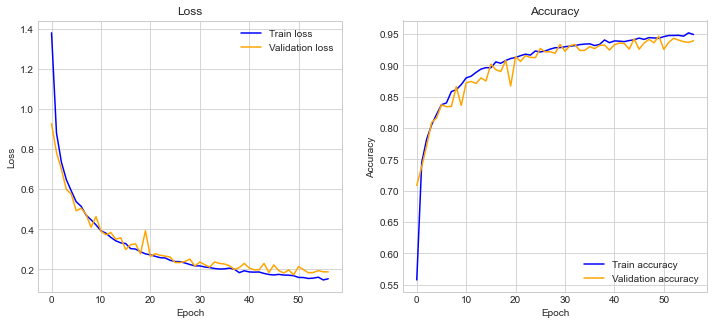

In [65]:
# configuration
BATCH_SIZE = 256
LEARNING_RATE = 0.0001
MAX_EPOCHS = 100
PATIENCE = 7

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# deterministic
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    AdversarialAugmentation(0.001),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load data
train_loader, val_loader, test_loader = load_data(root='data', train_transform=train_transform, 
                                                  test_transform=test_transform, batch_size=BATCH_SIZE)

# print some info
train_images, train_labels = next(iter(train_loader))
print(f"Images batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print("Device:", device)

# initialize model
model = CNN(input_dim=3, output_dim=10)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# train
start = time.time()
history = fit(model, train_loader, val_loader, optimizer=optimizer, checkpoint_name='cnn.pt', max_epochs=MAX_EPOCHS, 
              patience=PATIENCE, device=device)
end = time.time()
print("Training time:", calculate_time_span(start, end))

# predict
model = CNN(input_dim=3, output_dim=10)
model.load_state_dict(torch.load('cnn.pt'))  # load best model
y_test, y_pred = predict(model, test_loader, device)

# show results
show_results(history, y_test, y_pred)

Τα αποτελέσματα βλέπουμε πως είναι πολύ καλά καθώς το μοντέλο πέτυχε 94% accuracy στο test set, ενώ κοντά σε αυτή την τιμή είναι και οι σταθμισμένοι μέσοι των precision, recall και F1-score. Με βάση το F1-score κάθε κατηγορίας βλέπουμε πως λίγο πιο δύσκολα αναγνωρίζει τις κατηγορίες 5 και 6, δηλαδή Pasture και PermanentCrop αντίστοιχα. Στο early stopping χρησιμοποίησα patience 7, επομένως βλέπουμε ότι περίπου 50 εποχές είναι ο κατάλληλος αριθμός για εκπαίδευση και τα learning curves είναι ικανοποιητικά, χωρίς να φαίνεται πως έχει γίνει αξιοσημείωτο overfit.

In [75]:
from torchvision import models

## 2. Transfer learning

Τώρα θα χρησιμοποιήσω την τεχνική του transfer learning με το pretrained ResNet-152, εκπαιδεύοντας μόνο τα τελευταία layers. Και πάλι θα χρησιμοποιήσω τις ίδιες τεχνικές data augmentation.

In [76]:
class ResNet152(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ResNet152, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # load pretrained resnet152
        self.resnet152 = models.resnet152(pretrained=True)

        # freeze first layers
        for layer in list(self.resnet152.children())[:6]:
            for parameter in layer.parameters():
                parameter.requires_grad = False

        # redefine final layer
        self.resnet152.fc = nn.Linear(2048, output_dim)

    def forward(self, x):
        return self.resnet152(x)

Epoch: 1  -  loss: 0.5760348443243954  -  acc: 0.8374074074074074  -  val_loss: 0.2525199996307492  -  val_acc: 0.9195061728395062
Epoch: 2  -  loss: 0.1552725743401695  -  acc: 0.9479894179894179  -  val_loss: 0.17588742868974805  -  val_acc: 0.942716049382716
Epoch: 3  -  loss: 0.11630734987556934  -  acc: 0.9603174603174603  -  val_loss: 0.1282145967707038  -  val_acc: 0.9607407407407408
Epoch: 4  -  loss: 0.09765830998485153  -  acc: 0.9667724867724867  -  val_loss: 0.11132167628966272  -  val_acc: 0.965679012345679
Epoch: 5  -  loss: 0.0834697432111244  -  acc: 0.9725396825396826  -  val_loss: 0.10672502289526165  -  val_acc: 0.9649382716049383
Epoch: 6  -  loss: 0.07594406242306168  -  acc: 0.9743915343915344  -  val_loss: 0.10351022519171238  -  val_acc: 0.9671604938271605
Epoch: 7  -  loss: 0.061579441286724164  -  acc: 0.9795238095238096  -  val_loss: 0.11356757138855755  -  val_acc: 0.9629629629629629
Epoch: 8  -  loss: 0.05702609449272623  -  acc: 0.9798412698412698  -  val_

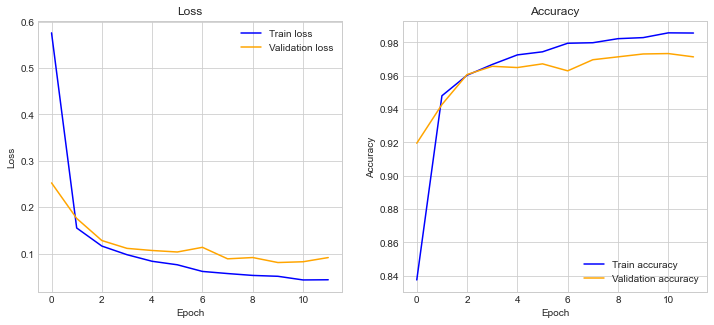

In [77]:
# configuration
BATCH_SIZE = 256
LEARNING_RATE = 0.00005
MAX_EPOCHS = 100
PATIENCE = 2

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# deterministic
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

# define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load data
train_loader, val_loader, test_loader = load_data(root='data', train_transform=train_transform, 
                                                  test_transform=test_transform, batch_size=BATCH_SIZE)

# initialize model
model = ResNet152(input_dim=3, output_dim=10)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# train
start = time.time()
history = fit(model, train_loader, val_loader, optimizer=optimizer, checkpoint_name='resnet.pt', max_epochs=MAX_EPOCHS, 
              patience=PATIENCE, device=device)
end = time.time()
print("Training time:", calculate_time_span(start, end))

#  predict
model = ResNet152(input_dim=3, output_dim=10)
model.load_state_dict(torch.load('resnet.pt'))  # load best model
y_test, y_pred = predict(model, test_loader, device)

# show results
show_results(history, y_test, y_pred)

Παρατηρούμε ότι με transfer learning, κάνοντας fine-tune μόνο τα τελευταία layers, όχι μόνο πετύχαμε καλύτερα αποτελέσματα με 97.2% accuracy στο test set, αλλά τα πετύχαμε σε λιγότερες εποχές και μικρότερο χρόνο εκπαίδευσης.

## 3. CNN with skip connections

Τέλος, εκπαιδεύω ένα CNN το οποίο χρησιμοποιεί skip connections σε κάθε block και είναι πιο βαθύ από το προηγούμενο.

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        # projection shortcut (1x1 convolution) to ensure same dimensions at the addition
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.shortcut(x) + self.conv(x)  # skip connection
        x = self.pool(x)
        return x


class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.conv = nn.Sequential(
            ResidualBlock(input_dim, 64),
            ResidualBlock(64, 128),
            ResidualBlock(128, 256),
            ResidualBlock(256, 512),
            ResidualBlock(512, 1024),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, output_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Epoch: 1  -  loss: 0.7291747698107282  -  acc: 0.738994708994709  -  val_loss: 0.6645507514476776  -  val_acc: 0.7735802469135803
Epoch: 2  -  loss: 0.4760099218503849  -  acc: 0.8283597883597884  -  val_loss: 0.5028200838714838  -  val_acc: 0.8237037037037037
Epoch: 3  -  loss: 0.39588431691801224  -  acc: 0.8576190476190476  -  val_loss: 0.5652407519519329  -  val_acc: 0.8195061728395062
Epoch: 4  -  loss: 0.3522550622756417  -  acc: 0.8768253968253968  -  val_loss: 0.42636912874877453  -  val_acc: 0.854320987654321
Epoch: 5  -  loss: 0.29825587691487493  -  acc: 0.896084656084656  -  val_loss: 0.3348403936251998  -  val_acc: 0.8923456790123456
Epoch: 6  -  loss: 0.2691206184996141  -  acc: 0.9053439153439153  -  val_loss: 0.3536761263385415  -  val_acc: 0.8817283950617284
Epoch: 7  -  loss: 0.23998599318233696  -  acc: 0.9156613756613756  -  val_loss: 0.344274434261024  -  val_acc: 0.8933333333333333
Epoch: 8  -  loss: 0.22379265383288666  -  acc: 0.9208465608465608  -  val_loss: 0.

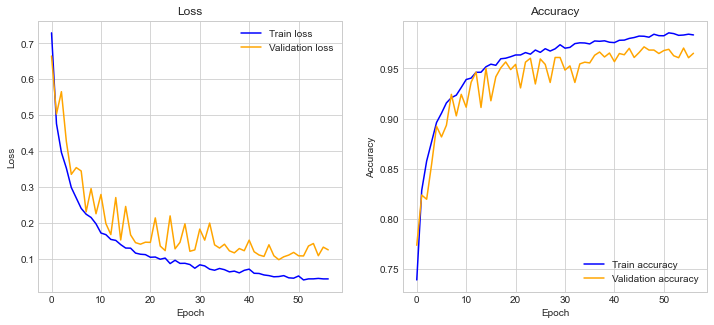

In [7]:
# configuration
BATCH_SIZE = 256
LEARNING_RATE = 0.0001
MAX_EPOCHS = 100
PATIENCE = 10

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# deterministic
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

# define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    AdversarialAugmentation(0.001),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load data
train_loader, val_loader, test_loader = load_data(root='data', train_transform=train_transform, 
                                                  test_transform=test_transform, batch_size=BATCH_SIZE)

# initialize model
model = CNN(input_dim=3, output_dim=10)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# train
start = time.time()
history = fit(model, train_loader, val_loader, optimizer=optimizer, checkpoint_name='cnn.pt', max_epochs=MAX_EPOCHS, 
              patience=PATIENCE, device=device)
end = time.time()
print("Training time:", calculate_time_span(start, end))

#  predict
model = CNN(input_dim=3, output_dim=10)
model.load_state_dict(torch.load('cnn.pt'))  # load best model
y_test, y_pred = predict(model, test_loader, device)

# show results
show_results(history, y_test, y_pred)

Χρησιμοποιώντας skip connections με πιο βαθιά αρχιτεκτονική τα αποτελέσματα βελτιώθηκαν σε σχέση με πριν έχοντας πλέον 97% accuracy στο test set, το οποίο είναι εξίσσου καλό και με το transfer learning. Το κόστος όμως ήταν αρκετά παραπάνω χρόνος εκπαίδευσης.